# Combining Color Histograms and HOG
In this notebook, I'll try out some different strategies for combining color histogram and HOG features for classification. There are several options for combining the two, including combining the feature vectors into one or having two steps in the classification process.

Before getting into that, I'll follow Kevin's suggestion and try clustering my roof samples to see if there are clear boundaries between different subclasses of roofs. If there are, then maybe I should have different classifiers to identify each subclass.

In [1]:
from utils import *
from features import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn import decomposition

%matplotlib inline

In [2]:
# Import image data
csv_in = '../data/imageData.csv'
hists, labels, le = import_image_data(csv_in)

In [3]:
# Get only roof data
indices = np.where(labels==1)
hists = hists[indices[0],:]
labels = labels[indices[0]]

In [4]:
# Calculate the 1st 2 PCA components
pca = decomposition.PCA(n_components=2)
pca.fit(hists)
X = pca.transform(hists)

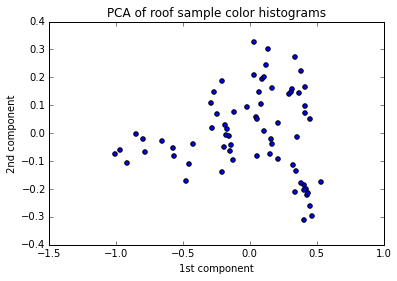

In [5]:
# Plot PCA decomposition of roof samples only
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.title('PCA of roof sample color histograms')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

There doesn't seem to be a real obvious way to cluster the roofs in our sample training set - let's come back to this later.

## Saving training data
The first thing that we need to do is compute color histograms, HOG features, and gradient magnitude histograms and store them in a pandas dataframe to be written to csv. I'd like to automate this processs so that I can just give the function a directory containing all of my training samples and it'll figure out which classes are there by looking at the names of the folders.

In [15]:
import glob
import os

In [16]:
sample_dir = '../images/samples/'
csv_out = '../data/all_image_data.csv'

In [30]:
# Setting column names of dataframe
columns = ['class', 'imageID', 'filename', 'width', 'height']
columns = columns + ['color' + str(i + 1) for i in range(48)]
columns = columns + ['hog' + str(i + 1) for i in range(9)]
columns = columns + ['mag' + str(i + 1) for i in range(16)]

In [31]:
# Create data frame for image data
image_data = pd.DataFrame(columns=columns)

In [32]:
# Keep track of total images processed
count_total = 0
start_time = time()
# Search sample directory for all sample class subdirectories
for class_dir in glob.iglob(sample_dir + '*'):
    # Get class name
    class_name = os.path.basename(class_dir)
    # Add data for each image in class subdirectory
    count_class = 0
    for image_path in glob.iglob(class_dir + '/*.png'):
        # Get image basename with extension
        image_fn = os.path.basename(image_path)
        # Get image ID
        imageID = image_fn[:-4]
        # Read in image and get dimensions
        image = cv2.imread(image_path)
        h, w = image.shape[:2]
        # Calculate color histogram
        color = calc_color_hist(image)
        color = np.transpose(color)
        # Create color histogram dataframe
        color_df = pd.DataFrame(color)
        col_names = list(color_df.columns.values)
        new_names = ['color' + str(i + 1) for i in col_names]
        color_df.columns = new_names
        # Calculate hog and gradient magnitude features
        (hog, hog_bins, mag, mag_bins, max_mag) = compute_hog(image)
        hog = hog.reshape(1, hog.size)
        mag = mag.reshape(1, mag.size)
        # Create hog dataframe
        hog_df = pd.DataFrame(hog)
        col_names = list(hog_df.columns.values)
        new_names = ['hog' + str(i + 1) for i in col_names]
        hog_df.columns = new_names
        # Create gradient magnitude dataframe
        mag_df = pd.DataFrame(mag)
        col_names = list(mag_df.columns.values)
        new_names = ['mag' + str(i + 1) for i in col_names]
        mag_df.columns = new_names
        # Create dataframe for image
        img_data = pd.DataFrame({'class': [class_name], 'imageID':\
                                 [imageID], 'filename': [image_fn],\
                                 'width': [w], 'height': [h]})
        img_data = pd.concat([img_data, color_df, hog_df, mag_df],\
                           axis=1)
        # Add new image data to image dataframe and continue indexing
        image_data = image_data.append(img_data, ignore_index=True)
        count_total += 1
        count_class += 1
    # Print update for class
    print 'Processed {} images for {} class.'.format(count_class,\
                                                     class_name)

end_time = time()
print 'Processed {} images total in {} seconds.'.format(count_total,\
                                            (end_time - start_time))

../images/samples/roofs
Processed 70 images for roofs class.
../images/samples/water
Processed 70 images for water class.
../images/samples/vegetation
Processed 70 images for vegetation class.
../images/samples/dirt
Processed 70 images for dirt class.
Processed 280 images total in 34.754201889 seconds.


In [33]:
# Drop rows with duplicated information
image_data.drop_duplicates(['class', 'filename'], inplace=True)
# Reorganize columns
image_data = image_data[columns]
# Writing image data to csv
image_data.to_csv(csv_out)

Right now it takes ~35 seconds to process 280 training samples. Let's put all of this code into one function so that in the future we can easily recompute image data for all of our training samples:

In [ ]:
import numpy as np
import pandas as pd
import glob
from time import time
import matplotlib.pyplot as plt
import os

In [50]:
def process_image(image_path, class_name, image_data):
    """
    This function process one image and adds its data to the dataframe
    containing all of the training image data.
    :param image_path: Path to image to process
    :param class_name: Class of image sample
    :param image_data: Dataframe containing training data
    :returns: Dataframe containing new image data
    """
    # Get image basename with extension
    image_fn = os.path.basename(image_path)
    # Get image ID
    imageID = image_fn[:-4]
    
    # Read in image and get dimensions
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    
    # Calculate color histogram
    color = calc_color_hist(image)
    color = np.transpose(color)
    # Create color histogram dataframe
    color_df = pd.DataFrame(color)
    col_names = list(color_df.columns.values)
    new_names = ['color' + str(i + 1) for i in col_names]
    color_df.columns = new_names
    
    # Calculate hog and gradient magnitude features
    (hog, hog_bins, mag, mag_bins, max_mag) = compute_hog(image)
    hog = hog.reshape(1, hog.size)
    mag = mag.reshape(1, mag.size)
    # Create hog dataframe
    hog_df = pd.DataFrame(hog)
    col_names = list(hog_df.columns.values)
    new_names = ['hog' + str(i + 1) for i in col_names]
    hog_df.columns = new_names
    
    # Create gradient magnitude dataframe
    mag_df = pd.DataFrame(mag)
    col_names = list(mag_df.columns.values)
    new_names = ['mag' + str(i + 1) for i in col_names]
    mag_df.columns = new_names
    
    # Create dataframe for image
    img_data = pd.DataFrame({'class': [class_name], 'imageID':\
                             [imageID], 'filename': [image_fn],\
                             'width': [w], 'height': [h]})
    img_data = pd.concat([img_data, color_df, hog_df, mag_df],\
                       axis=1)
    
    # Add new image data to image dataframe and continue indexing
    return image_data.append(img_data, ignore_index=True)

In [51]:
def store_image_data(image_dir, csv_out):
    """
    This function goes through each of the class sample directories
    within the samples directory and computes color histogram and HOG
    features for each image within, then writes the data to a csv file
    for later use.
    :param image_dir: Path to the directory containing image samples
    :param csv_out: Path of output csv file containing data
    """
    start_time = time()
    
    # Setting column names of dataframe
    columns = ['class', 'imageID', 'filename', 'width', 'height']
    columns = columns + ['color' + str(i + 1) for i in range(48)]
    columns = columns + ['hog' + str(i + 1) for i in range(9)]
    columns = columns + ['mag' + str(i + 1) for i in range(16)]
    
    # Create data frame for image data
    image_data = pd.DataFrame(columns=columns)
    
    # Keep track of total images processed
    count_total = 0
    
    # Search sample directory for all sample class subdirectories
    for class_dir in glob.iglob(sample_dir + '*'):
        # Get class name
        class_name = os.path.basename(class_dir)
        # Add data for each image in class subdirectory
        count_class = 0
        for image_path in glob.iglob(class_dir + '/*.png'):
            # Add data for each image
            image_data = process_image(image_path, class_name,\
                                       image_data)
            count_total += 1
            count_class += 1
        # Print update for class
        print 'Processed {} images for {} class.'.format(count_class,\
                                                         class_name)
    
    # Drop rows with duplicated information
    image_data.drop_duplicates(['class', 'filename'], inplace=True)
    # Reorganize columns
    image_data = image_data[columns]
    # Writing image data to csv
    image_data.to_csv(csv_out)
    end_time = time()
    print 'Processed {} images total in {} seconds.'.format(count_total,\
                                                (end_time - start_time))

Let's test out the function!

In [52]:
store_image_data(sample_dir, csv_out)

Processed 70 images for roofs class.
Processed 70 images for water class.
Processed 70 images for vegetation class.
Processed 70 images for dirt class.
Processed 280 images total in 34.5588610172 seconds.


It works!